# GPT Model from Scratch

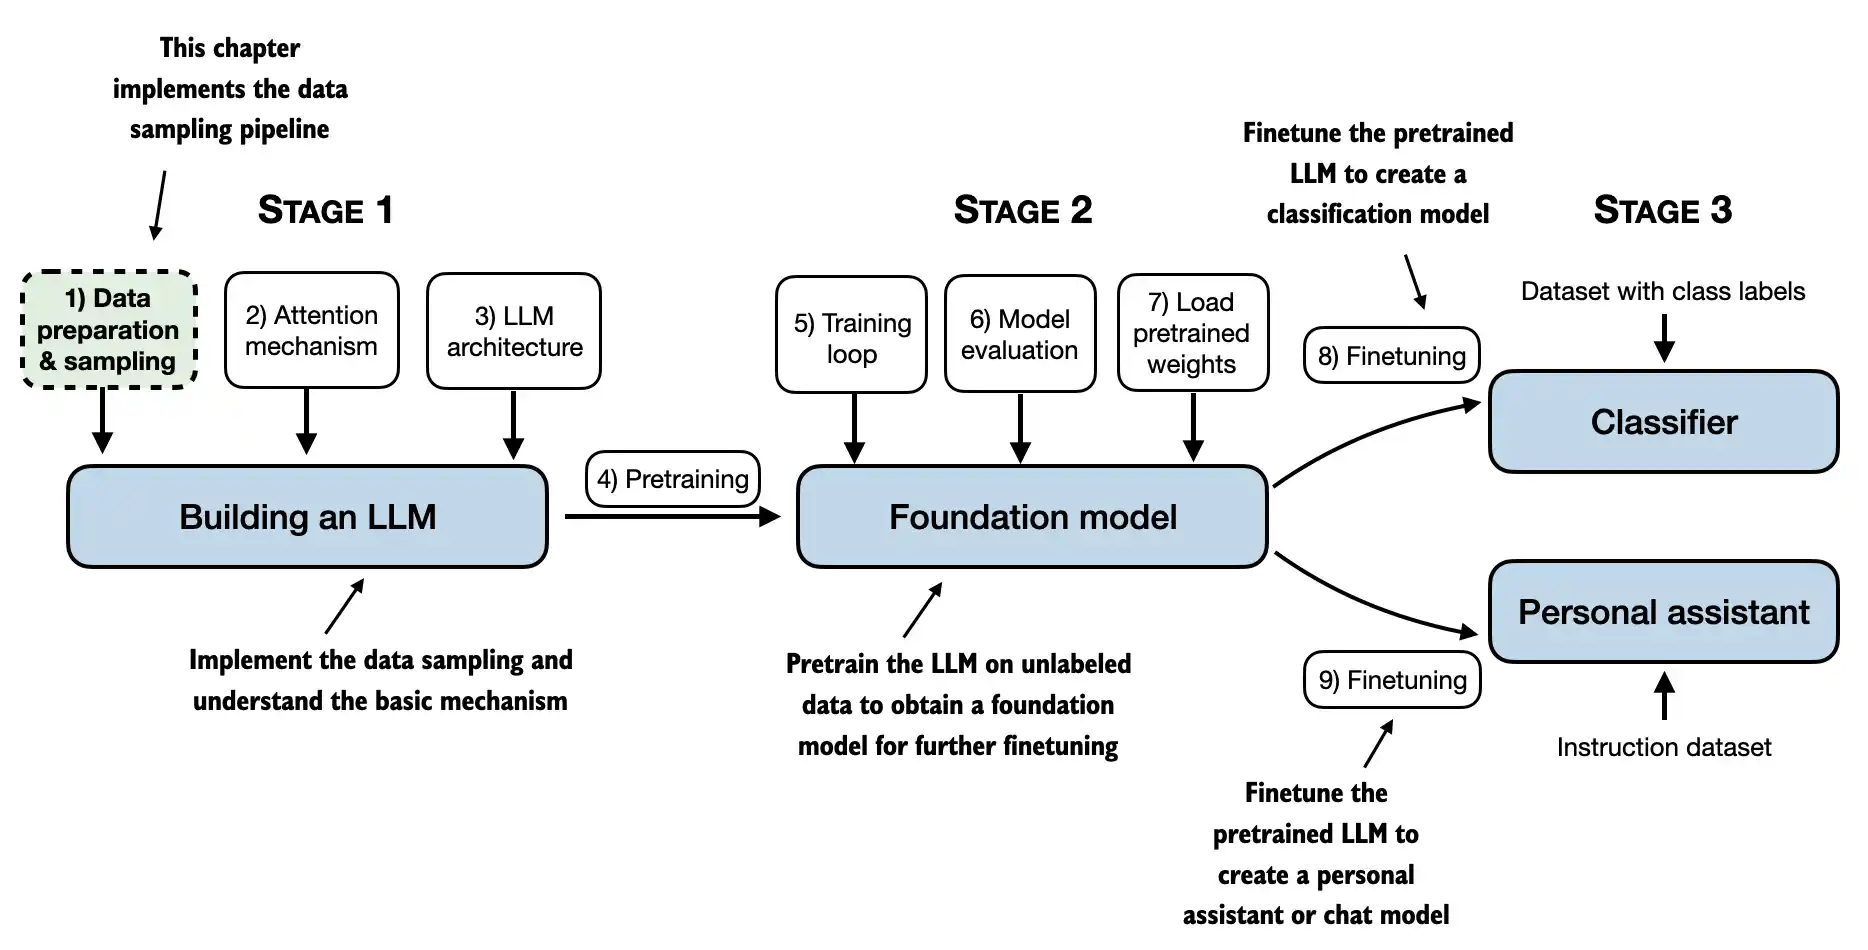

# Part 01: Data Loader & Embeddings

## Data Loader

**Tokenization**

Breaking text into smaller units, such as individual words and punctuation characters

I am using `tiktoken` library to implement the tokenization.I am using `gpt2` tokenizer. Tokenizer by default does not understand the special tokens like `<|endoftext|>`
We need to pass the parameter `allowed_special = {"<|endoftext|>"}`

`Sentence -> tokens -> token ids -> embeddings`

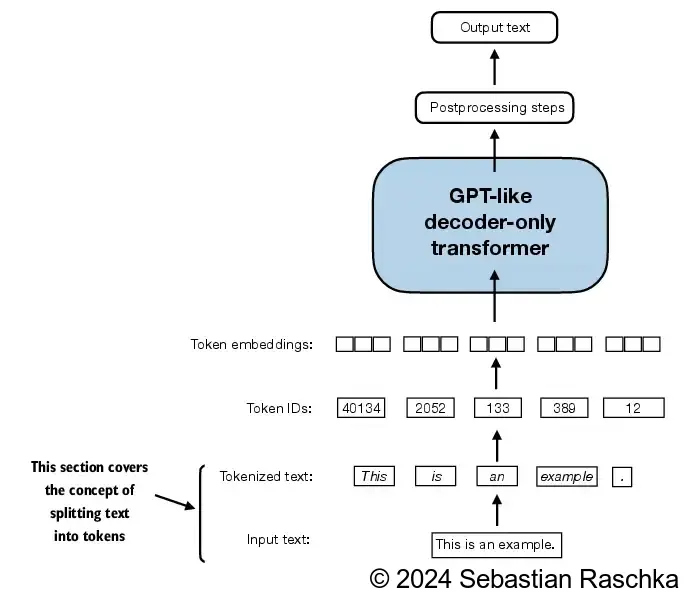

In [20]:
# Loading the Dataset

# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [58]:
import tiktoken
encoding = tiktoken.encoding_for_model("gpt2")

vocab_size = encoding.n_vocab
print(vocab_size) 

def encoder(text):
    return encoding.encode(text,  allowed_special = {"<|endoftext|>"})

def decoder(tokens):
    return encoding.decode(tokens)

tokens = encoder("I am a boy <|endoftext|>")
print(tokens)
print(decoder(tokens))

50257
[40, 716, 257, 2933, 220, 50256]
I am a boy <|endoftext|>


## Data sampling with a sliding window

We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:

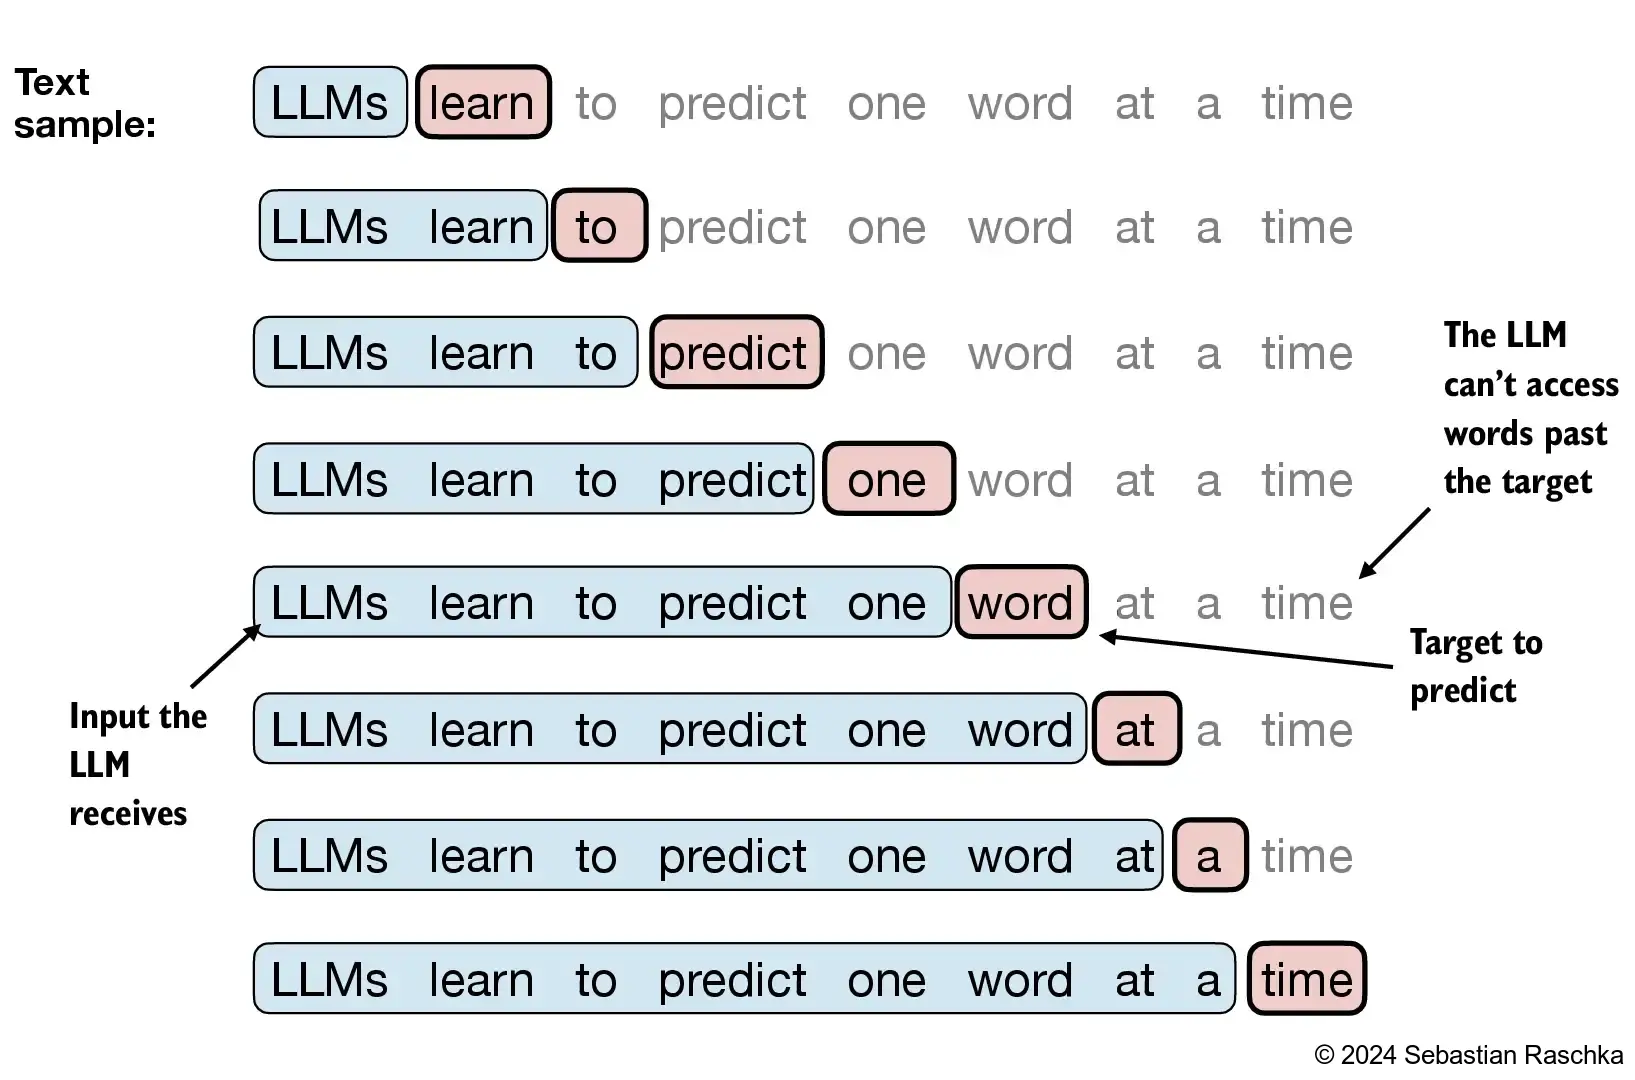

In [61]:
tokens = encoder(text)
print(len(tokens))

vocab_size = len(list( set(tokens)))

print(len(list( set(tokens))))

338025
11706


In [62]:
context_length = 5

x = tokens[:context_length]
y = tokens[1: context_length +1 ]

print(f"Input --> {x} ")
print(f"Target -->      {y} ")

Input --> [5962, 22307, 25, 198, 8421] 
Target -->      [22307, 25, 198, 8421, 356] 


In [63]:
for i in range(1, context_length+1):
    input_ids = tokens[:i]
    output_ids = tokens[i]

    print(f"{input_ids} --> {output_ids}")
    print(f"{decoder(input_ids)} --> {decoder([output_ids])}")
    

[5962] --> 22307
First -->  Citizen
[5962, 22307] --> 25
First Citizen --> :
[5962, 22307, 25] --> 198
First Citizen: --> 

[5962, 22307, 25, 198] --> 8421
First Citizen:
 --> Before
[5962, 22307, 25, 198, 8421] --> 356
First Citizen:
Before -->  we


In [68]:
from torch.utils.data import Dataset, DataLoader
import torch

class GPTDataLoaderv1(Dataset):
    def __init__(self, text, context_length, stride):
        self.input_ids = []
        self.output_ids = []

        token_ids = encoder(text)

        for i in range(0, len(token_ids) - context_length, stride):
            input_chunk = token_ids[i:i+context_length]
            output_chunk = token_ids[i+1:i+context_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.output_ids.append(torch.tensor(output_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.output_ids[idx]

In [69]:
def data_loader(text, context_length, stride, batch_size, shuffle, drop_last, num_workers):
    dataset = GPTDataLoaderv1(
        text=text,
        context_length=context_length,
        stride=stride
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle=shuffle,
        drop_last= drop_last,
        num_workers=num_workers
    )

    return dataloader

In [70]:
dataloader = data_loader(
    text=text,
    context_length=4,
    stride=4,
    drop_last=True,
    shuffle=True,
    batch_size=8,
    num_workers=0
)

In [71]:
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[  287, 30618,    11,   198],
        [  198,    46,    11,   287],
        [  328,   540, 14404,    11],
        [  371, 20739,  9795,  6711],
        [  516,    13,   198,   198],
        [  588,   257, 26844,  9717],
        [ 2501,   766,   502,  1752],
        [11906,  7739,     0,   788]])

Targets:
 tensor([[30618,    11,   198,  1870],
        [   46,    11,   287,   428],
        [  540, 14404,    11,   198],
        [20739,  9795,  6711,    25],
        [   13,   198,   198,  5962],
        [  257, 26844,  9717,   198],
        [  766,   502,  1752,   517],
        [ 7739,     0,   788,    11]])


## Creating token embeddings

In [26]:
input_ids = torch.tensor([2,3,4,5])

vocab_size = 6
d_model = 2

torch.manual_seed(123)

embedding = torch.nn.Embedding(vocab_size, d_model)
embedding.weight

Parameter containing:
tensor([[-0.1115,  0.1204],
        [-0.3696, -0.2404],
        [-1.1969,  0.2093],
        [-0.9724, -0.7550],
        [ 0.3239, -0.1085],
        [ 0.2103, -0.3908]], requires_grad=True)

In [22]:
embedding(input_ids)

tensor([[-1.1969,  0.2093],
        [-0.9724, -0.7550],
        [ 0.3239, -0.1085],
        [ 0.2103, -0.3908]], grad_fn=<EmbeddingBackward0>)

## Encoding word positions

In [37]:
d_model = 256
vocab_size = 297606

token_embedding_layer = torch.nn.Embedding(vocab_size, d_model)

In [38]:
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[  364, 13090,    56,   734],
        [   44, 62148, 14313,  3042],
        [ 4561,   412,  3436, 16387],
        [ 2886, 78988,   328, 55314],
        [  922, 42668,   306,   634],
        [  734, 16528,    11,   922],
        [ 1917,   364,  5680,   493],
        [  734, 22515,    11,   484]])

Inputs shape:
 torch.Size([8, 4])


In [39]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [46]:
# absolute position embeddings

# context_length --> NUmber of Tokens ( 05 Right Now )
# d_model --> dimentions of embedding ( 512 dimention )

context_length = 4

pos_embedding_layer = torch.nn.Embedding(context_length, d_model)
print(pos_embedding_layer.weight)

Parameter containing:
tensor([[-0.9991, -0.2458,  0.3746,  ..., -1.0886,  1.2257,  0.2631],
        [-0.3015, -0.0972, -0.3987,  ..., -0.1584, -2.0231,  0.5463],
        [ 0.0720, -1.5106, -0.7817,  ...,  2.1539,  0.5415,  0.6499],
        [-1.2706,  0.4879, -1.7764,  ...,  0.1314, -1.3818, -0.4708]],
       requires_grad=True)


In [47]:
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
print(pos_embeddings)

torch.Size([4, 256])
tensor([[-0.9991, -0.2458,  0.3746,  ..., -1.0886,  1.2257,  0.2631],
        [-0.3015, -0.0972, -0.3987,  ..., -0.1584, -2.0231,  0.5463],
        [ 0.0720, -1.5106, -0.7817,  ...,  2.1539,  0.5415,  0.6499],
        [-1.2706,  0.4879, -1.7764,  ...,  0.1314, -1.3818, -0.4708]],
       grad_fn=<EmbeddingBackward0>)


In [50]:
# Embeddings 

input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


## Complete Code

In [2]:
import tiktoken

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

encoding = tiktoken.encoding_for_model("gpt2")
vocab_size = encoding.n_vocab
print(vocab_size) 

def encoder(text):
    return encoding.encode(text,  allowed_special = {"<|endoftext|>"})

def decoder(tokens):
    return encoding.decode(tokens)

50257


In [3]:
from torch.utils.data import Dataset, DataLoader
import torch

class GPTDataLoaderv1(Dataset):
    def __init__(self, text, context_length, stride):
        self.input_ids = []
        self.output_ids = []

        token_ids = encoder(text)

        for i in range(0, len(token_ids) - context_length, stride):
            input_chunk = token_ids[i:i+context_length]
            output_chunk = token_ids[i+1:i+context_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.output_ids.append(torch.tensor(output_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.output_ids[idx]

def data_loader(text, context_length, stride, batch_size, shuffle, drop_last, num_workers):
    dataset = GPTDataLoaderv1(
        text=text,
        context_length=context_length,
        stride=stride
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle=shuffle,
        drop_last= drop_last,
        num_workers=num_workers
    )

    return dataloader


dataloader = data_loader(
    text=text,
    context_length=4,
    stride=4,
    drop_last=True,
    shuffle=True,
    batch_size=8,
    num_workers=0
)

In [8]:
import torch

class Embedding(torch.nn.Module):
    def __init__(self, vocab_size, d_model, context_length):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.context_length = context_length
        self.token_embedding = torch.nn.Embedding(vocab_size, d_model)
        self.pos_embedding = torch.nn.Embedding(context_length, d_model)

    def forward(self, x):
        x = self.token_embedding(x) + self.pos_embedding(torch.arange(self.context_length))
        return x
        

In [9]:
d_model = 256
vocab_size = 50257
context_length = 4

embedder = Embedding(
    vocab_size = 50257,
    d_model = 256,
    context_length = 4)

In [10]:
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

embeddings = embedder(inputs)

In [12]:
embeddings.shape

torch.Size([8, 4, 256])

# Part 02: Self Attention & Masked Attention

## Simple Self Attention

In [31]:
import torch.nn as nn
import torch

class SimpleAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model 
        self.w_q = nn.Linear(in_features=d_model, out_features = d_model, bias=False)
        self.w_k = nn.Linear(in_features=d_model, out_features = d_model, bias=False)
        self.w_v = nn.Linear(in_features=d_model, out_features = d_model, bias=False)

    def forward(self, x):
        Q = self.w_q(x)
        K = self.w_k(x)
        V = self.w_v(x)
        
        Q_k = (Q @ K.T) / self.d_model**0.5
        attention_scores = torch.softmax(Q_k, dim=-1)
        final_attention_scores = attention_scores @ V
        
        return final_attention_scores

In [32]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

attention = SimpleAttention(d_model=3)
attention_output = attention(inputs)
print(attention_output)

tensor([[-0.0167, -0.3913, -0.2800],
        [-0.0149, -0.3882, -0.2807],
        [-0.0149, -0.3882, -0.2806],
        [-0.0127, -0.3846, -0.2817],
        [-0.0142, -0.3867, -0.2807],
        [-0.0126, -0.3848, -0.2819]], grad_fn=<MmBackward0>)


## Simple Masked Attention

In [45]:
Q_k = torch.tensor([[-0.0349,  0.1471,  0.1421,  0.1123,  0.0118,  0.1645],
        [ 0.0453,  0.2283,  0.2252,  0.1452,  0.1053,  0.1828],
        [ 0.0454,  0.2254,  0.2221,  0.1437,  0.1007,  0.1825],
        [ 0.0340,  0.1284,  0.1276,  0.0775,  0.0774,  0.0895],
        [ 0.0328,  0.1091,  0.1044,  0.0769, -0.0105,  0.1260],
        [ 0.0350,  0.1650,  0.1653,  0.0971,  0.1248,  0.0994]])

Q_k2 = Q_k

In [46]:
mask = torch.triu(torch.ones(6,6), diagonal=1)
mask

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [47]:
Q_k.masked_fill(mask.bool(), -torch.inf)

tensor([[-0.0349,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.0453,  0.2283,    -inf,    -inf,    -inf,    -inf],
        [ 0.0454,  0.2254,  0.2221,    -inf,    -inf,    -inf],
        [ 0.0340,  0.1284,  0.1276,  0.0775,    -inf,    -inf],
        [ 0.0328,  0.1091,  0.1044,  0.0769, -0.0105,    -inf],
        [ 0.0350,  0.1650,  0.1653,  0.0971,  0.1248,  0.0994]])

In [51]:
# Lets Suppose 

token_number = 6
Q_k2.masked_fill(mask.bool()[:token_number, :token_number], -torch.inf)

tensor([[-0.0349,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.0453,  0.2283,    -inf,    -inf,    -inf,    -inf],
        [ 0.0454,  0.2254,  0.2221,    -inf,    -inf,    -inf],
        [ 0.0340,  0.1284,  0.1276,  0.0775,    -inf,    -inf],
        [ 0.0328,  0.1091,  0.1044,  0.0769, -0.0105,    -inf],
        [ 0.0350,  0.1650,  0.1653,  0.0971,  0.1248,  0.0994]])

In [67]:
import torch.nn as nn
import torch

class MaskedAttention(nn.Module):
    def __init__(self, d_model, context_length, drop_out):
        super().__init__()
        self.d_model = d_model 
        self.w_q = nn.Linear(in_features=d_model, out_features = d_model, bias=False)
        self.w_k = nn.Linear(in_features=d_model, out_features = d_model, bias=False)
        self.w_v = nn.Linear(in_features=d_model, out_features = d_model, bias=False)
        self.drop_out = nn.Dropout(drop_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        num_tokens, d_out = x.shape
        
        Q = self.w_q(x)
        K = self.w_k(x)
        V = self.w_v(x)
        
        Q_k = (Q @ K.T) / self.d_model**0.5
        Q_k.masked_fill(self.mask.bool(), -torch.inf)
        attention_scores = torch.softmax(Q_k, dim=-1)
        final_attention_scores = attention_scores @ V
        
        return final_attention_scores

In [68]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

context_length = inputs.shape[0]
drop_out = 0.0

attention = MaskedAttention(d_model=3, context_length=context_length, drop_out= drop_out)
attention_output = attention(inputs)
print(attention_output)

tensor([[0.2302, 0.0521, 0.0074],
        [0.2339, 0.0542, 0.0085],
        [0.2335, 0.0536, 0.0086],
        [0.2350, 0.0524, 0.0099],
        [0.2266, 0.0415, 0.0099],
        [0.2384, 0.0581, 0.0093]], grad_fn=<MmBackward0>)


## Maked Attention with Batched Input

In [92]:
import torch.nn as nn
import torch

class MaskedAttention(nn.Module):
    def __init__(self, d_model, context_length, drop_out):
        super().__init__()
        self.d_model = d_model 
        self.w_q = nn.Linear(in_features=d_model, out_features = d_model, bias=False)
        self.w_k = nn.Linear(in_features=d_model, out_features = d_model, bias=False)
        self.w_v = nn.Linear(in_features=d_model, out_features = d_model, bias=False)
        self.drop_out = nn.Dropout(drop_out)
        
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
        # register_buffer will register this mask tensor to the GPU if we move to GPU

    def forward(self, x):
        # Shape of x -> (2, 6, 3)
        b, num_tokens, d_out = x.shape
        
        Q = self.w_q(x)
        K = self.w_k(x)
        V = self.w_v(x)

        # Shape of Q -> (2, 6, 3)
        # Shape of K -> (2, 6, 3)
        # To do the matrix multiplication we need to switch the 1 and 2 dimention of the K
        # After transpose(1, 2) Shape of K -> (2, 3, 6)
        # Now Q @ K --> (2, 6, 3) @ (2, 3, 6) 
        
        Q_k = (Q @ K.transpose(1,2)) / self.d_model**0.5
        Q_k.masked_fill(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attention_scores = torch.softmax(Q_k, dim=-1)
        final_attention_scores = attention_scores @ V
        attention = self.drop_out(final_attention_scores)
        
        return attention

In [98]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

batched_input = torch.stack((inputs, inputs))

context_length = batched_input.shape[1]
drop_out = 0.5

attention = MaskedAttention(d_model=3, context_length=context_length, drop_out= drop_out)
attention_output = attention(batched_input)
print(attention_output)

tensor([[[-0.0000,  0.0000, -0.0000],
         [-0.0000,  0.0000, -0.0872],
         [-0.1587,  0.0000, -0.0000],
         [-0.0000,  0.3355, -0.0924],
         [-0.0000,  0.0000, -0.0956],
         [-0.1583,  0.3325, -0.0893]],

        [[-0.0000,  0.3306, -0.0000],
         [-0.0000,  0.0000, -0.0000],
         [-0.1587,  0.3324, -0.0000],
         [-0.0000,  0.3355, -0.0924],
         [-0.1558,  0.0000, -0.0956],
         [-0.1583,  0.3325, -0.0000]]], grad_fn=<MulBackward0>)


## Multihead Attention

In [101]:
class MultiHeadAttentionv1(nn.Module):
    def __init__(self, d_model, context_length, drop_out, num_heads):
        super().__init__()
        self.heads = nn.ModuleList([MaskedAttention(d_model=3, context_length=context_length, drop_out= drop_out) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([ head(x) for head in self.heads ], dim=-1)


In [104]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

batched_input = torch.stack((inputs, inputs))

context_length = batched_input.shape[1]
drop_out = 0.5

attention = MultiHeadAttentionv1(d_model=3, context_length=context_length, drop_out= drop_out, num_heads=2)
attention_output = attention(batched_input)
print(attention_output)

tensor([[[-0.8421,  0.9618, -0.0000,  0.0000,  0.0000, -0.0000],
         [-0.0000,  0.0000, -0.0000,  0.0000,  0.5873, -0.0000],
         [-0.8432,  0.0000, -0.0000,  0.0000,  0.0000, -0.7440],
         [-0.8395,  0.9579, -0.0000,  0.5451,  0.5879, -0.7428],
         [-0.8367,  0.9550, -0.0000,  0.0000,  0.5813, -0.7378],
         [-0.0000,  0.0000, -0.5343,  0.0000,  0.5906, -0.7454]],

        [[-0.0000,  0.9618, -0.0000,  0.5406,  0.5812, -0.0000],
         [-0.8434,  0.9632, -0.5334,  0.5468,  0.5873, -0.0000],
         [-0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.7440],
         [-0.8395,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000],
         [-0.8367,  0.0000, -0.5274,  0.0000,  0.0000, -0.7378],
         [-0.0000,  0.9609, -0.0000,  0.0000,  0.5906, -0.7454]]],
       grad_fn=<CatBackward0>)


In [168]:
import torch 
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, context_length, drop_out):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_model // num_heads
        self.drop_out = nn.Dropout(drop_out)

        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        b, num_tokens, d_out = x.shape 
        Q = self.w_k(x)
        K = self.w_k(x)
        V = self.w_v(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        
        queries = Q.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = K.view(b, num_tokens, self.num_heads, self.head_dim)
        values = V.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)

        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # Shape of queries --> [2, 2, 6, 2]
        # Shape of Keys --> [2, 2, 6, 2]
        #  To perform the multiplication we need to transpose the Keys matrix to [2, 2, 2, 6]
        # keys.transpose(2, 3) --> [2, 2, 2, 6]

        Q_k = queries @ keys.transpose(2, 3)
        attention = Q_k.masked_fill( self.mask.bool()[:num_tokens, :num_tokens], -torch.inf )
        attention_weight = torch.softmax( attention / self.d_model**0.5, dim=-1)
        attention_weight = self.drop_out(attention_weight)
        final_attention_score = attention_weight @ values
        conetxt_vec = final_attention_score.transpose(1, 2)
        final_conetxt_vect = conetxt_vec.reshape(b, num_tokens, d_out)

        return final_conetxt_vect
        
        

In [169]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89, 0.78], # Your     (x^1)
   [0.55, 0.87, 0.66, 0.90], # journey  (x^2)
   [0.57, 0.85, 0.64, 0.89], # starts   (x^3)
   [0.22, 0.58, 0.33,0.55], # with     (x^4)
   [0.77, 0.25, 0.10, 0.78], # one      (x^5)
   [0.05, 0.80, 0.55, 0.22]] # step     (x^6)
)

batch_input = torch.stack((inputs, inputs))
batch_input.shape

multihead = MultiHeadAttention(
    d_model = 4,
    context_length=batch_input.shape[1],
    num_heads = 2,
    drop_out=0.0
)

multihead(batch_input)

tensor([[[ 0.9602, -0.1338, -0.7208, -0.4869],
         [ 1.1165, -0.1131, -0.7633, -0.4430],
         [ 1.1656, -0.1024, -0.7769, -0.4237],
         [ 1.0573, -0.0908, -0.6947, -0.3776],
         [ 1.0060, -0.0339, -0.6931, -0.3205],
         [ 0.9570, -0.0685, -0.6252, -0.3178]],

        [[ 0.9602, -0.1338, -0.7208, -0.4869],
         [ 1.1165, -0.1131, -0.7633, -0.4430],
         [ 1.1656, -0.1024, -0.7769, -0.4237],
         [ 1.0573, -0.0908, -0.6947, -0.3776],
         [ 1.0060, -0.0339, -0.6931, -0.3205],
         [ 0.9570, -0.0685, -0.6252, -0.3178]]], grad_fn=<UnsafeViewBackward0>)

# Part 03 GPT Model

In [172]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension (d_model in the paper)
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [184]:
import tiktoken 
encoder = tiktoken.get_encoding("gpt2")

text = [
    "Every effort moves you",
    "Every day holds a"
]

batch_input = [torch.tensor(encoder.encode(s)) for s in text]
batch_input = torch.stack(batch_input, dim=0)
batch_input.shape

torch.Size([2, 4])

## Layer Normalization

I will be using `torch's` build in `LayerNorm` to implemen the Normalization layer

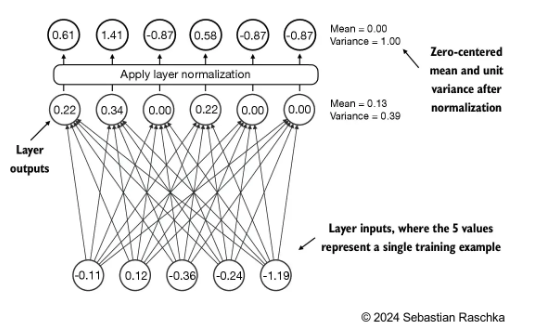

In [215]:
class LayerNorm(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.context_length = config["context_length"]
        self.layer_norm = nn.LayerNorm(config["emb_dim"])

    def forward(self, x):
        x = self.layer_norm(x)
        return x

## FeedForward Neural Netwrok

I will be using `GELU` activation funtion. Especially the `tanh` version. The original GPT-2 model was also trained with this approximation)

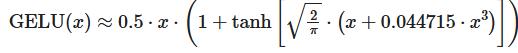

In [237]:
class FeedForwardLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"], 4*config["emb_dim"]),
            nn.GELU(approximate='tanh'),
            nn.Linear(4*config["emb_dim"], config["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)

## Transformer Block

Suppose we have 2 input samples with 4 tokens each, where each token is a 768-dimensional embedding vector; then this transformer block applies self-attention, followed by linear layers, to produce an output of similar size

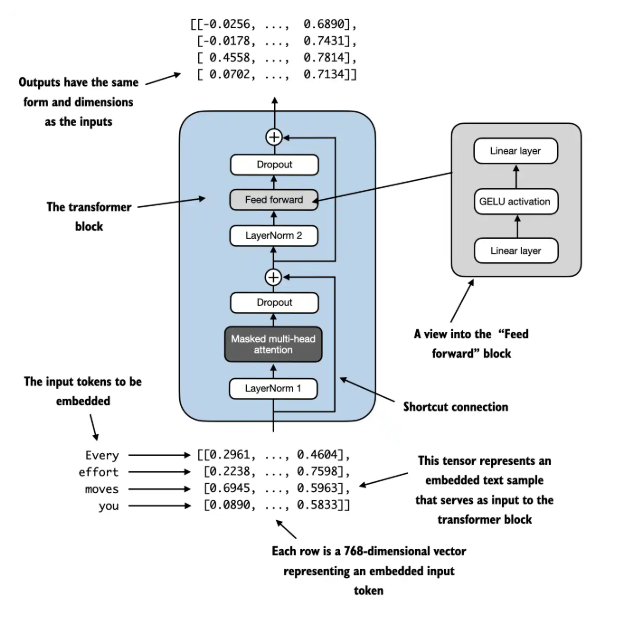

In [238]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.multihead_attn = MultiHeadAttention(
                                        d_model = config["emb_dim"] ,
                                        context_length=config["context_length"],
                                        num_heads = config["n_heads"] ,
                                        drop_out=config["drop_rate"]
                                    )
        self.layer_norm1 = LayerNorm(config)
        self.layer_norm2 = LayerNorm(config)
        self.dense_layer = FeedForwardLayer(config)
        self.drop_out = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.layer_norm1(x)
        x = self.multihead_attn(x)
        x = self.drop_out(x)
        x = x + shortcut

        shortcut = x
        x = self.layer_norm2(x)
        x = self.dense_layer(x)
        x = self.drop_out(x)
        x = x + shortcut

        return x

## GPT Model

 transformer block is repeated multiple times; in the case of the smallest 124M GPT-2 model, we repeat it 12 times

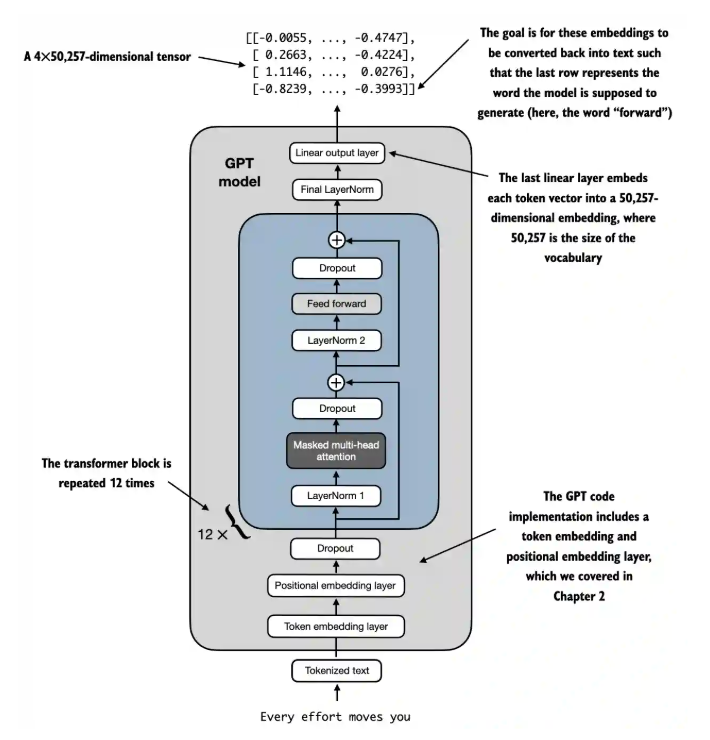

In [254]:
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.word_embeddings = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_embeddings = nn.Embedding(config["context_length"], config["emb_dim"])  # Craeting a Embedding Layer with context length of 1024
        self.drop_out = nn.Dropout(config["drop_rate"])
        self.layer_norm= LayerNorm(config)
        self.transformer = nn.Sequential(*[Transformer(config) for _ in range(config["n_layers"])])
        self.output_layer = nn.Linear(config["emb_dim"], config["vocab_size"])
    
    def forward(self, x):
        b, conetxt_length = x.shape
        x = self.word_embeddings(x) + self.pos_embeddings(torch.arange(conetxt_length)) # Positional Embedding for the input token seq. length
        x = self.drop_out(x)
        
        # Shape of the mtrix going in the transformer and going out must be the same input: [2, 4, 768] --> output: [2, 4, 768]
        x = self.transformer(x)  
        x = self.layer_norm(x)
        x = self.output_layer(x)
        return x

## GPT Model Parameters

In [257]:
#  numel() --> number of elements

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 155,972,689


In [258]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 594.99 MB


## Taking test Output

LLMs like the GPT model we implemented above are used to generate one word at a time

- The following generate_text_simple function implements greedy decoding, which is a simple and fast method to generate text
- In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly)
- In the next chapter, we will implement a more advanced generate_text function
- The figure below depicts how the GPT model, given an input context, generates the next word token

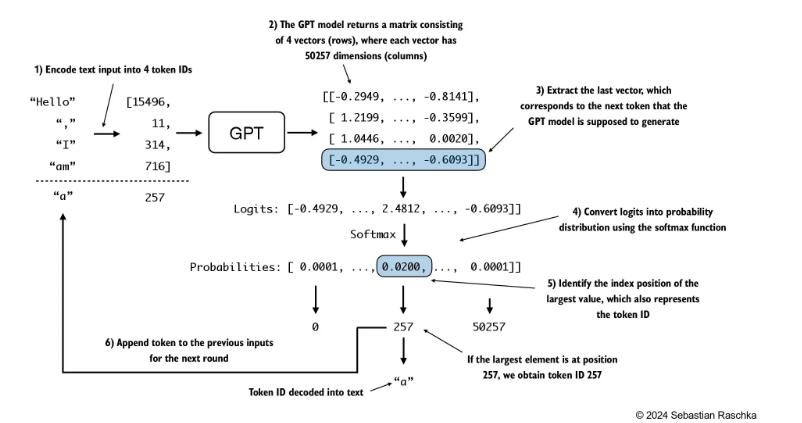

In [308]:
def generate_text(input_tokens, model, context_length, max_new_tokens):
    for _ in range(max_new_tokens):
        tokens = input_tokens[:, -context_length:]

        with torch.no_grad():
            output = model(tokens)
            # Output Shape --> [1, 4, 50257] Means we have one Batch with 4 Rows ( number fo tokens ) and each token has embedding of size 50257

        output = output[:, -1, :]
        probs = torch.softmax(output, dim=-1)
        generated_token = torch.argmax(probs, dim=-1, keepdim=True)
        
        return torch.cat((input_tokens, generated_token), dim=1)

In [324]:
# Test Input 

input_sentence = "My Name Is sajeel"
inputs = torch.tensor(encoder.encode(input_sentence)).unsqueeze(0)   # Input Shape --> [1, 4]

model = GPTModel(config=GPT_CONFIG_124M)

output = generate_text(
    input_tokens=inputs,
    model=model,
    context_length=GPT_CONFIG_124M["context_length"],
    max_new_tokens=5
)


In [325]:
encoder.decode(output.squeeze(0).tolist())

'My Name Is sajeel seaw'